<a href="https://colab.research.google.com/github/HanzlaJavaid/Brain-Computing-Interface/blob/main/BCI_Mindwave_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,MinMaxScaler
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dropout,Dense,BatchNormalization
import keras.datasets as dfs

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df = pd.read_csv("/content/drive/MyDrive/tutorial_tea2.csv")
df = df.iloc[:,1:]
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50
0,9590.0,11.300536,16.828072,1.400612,1.634333,2.411865,5.170004,8.554547,4.118052,1.826552,5.698843,9.336993,10.632069,5.384311,5.889308,0.442510,2.404258,2.830158,10.488135,2.441550,2.577034,7.289679,6.579761,8.268516,12.163783,3.236068,4.618484,1.437328,2.434311,3.138683,4.411696,4.938875,5.738091,13.700829,8.716755,5.261370,1.573790,8.751183,0.692568,1.794926,0.520871,0.520564,7.017794,0.516539,8.201628,10.556871,6.020826,5.320554,0.162637,0.812393,0.0
1,9504.0,186.547966,48.161608,47.643909,29.981965,6.923306,9.515621,15.141497,6.182643,6.023226,0.594818,5.594211,21.384321,15.081472,8.579979,9.557710,8.350403,21.667410,20.552948,33.842606,16.407768,12.787555,19.026249,2.033633,13.964163,4.236068,5.838238,14.308867,6.700240,1.783596,6.062528,15.723982,5.414117,0.416556,8.461486,0.988839,8.975479,0.210953,11.907894,7.179679,12.635933,7.604407,1.819345,2.017215,2.458946,4.872544,6.194032,0.316579,9.416109,0.562300,0.0
2,9.0,2633.040665,2287.478624,1771.287629,309.794359,27.582506,16.000324,232.307107,206.486298,125.184790,152.257094,98.886227,46.281465,147.103274,257.058691,50.178313,174.418496,155.130589,256.105450,209.535137,69.393794,198.736685,120.136660,104.012231,95.475844,81.749224,34.524361,62.958989,31.259697,138.596013,225.012448,32.013311,145.028081,17.107261,84.099332,40.147784,13.720291,202.183254,109.031575,43.801175,22.337481,108.106247,2.221497,152.772591,111.418959,78.005532,64.694415,76.465589,153.944915,110.573626,0.0
3,23921.0,62.654756,17416.921433,7584.957042,5884.416924,7660.819742,1691.052505,3812.562625,5568.151603,1894.201292,2930.546661,4780.962983,327.071449,2085.256466,4208.939402,10.418293,2579.309481,3243.220760,912.893550,2972.538699,3764.328739,538.898921,3935.692664,2946.758382,3219.685761,3894.709444,700.237741,2235.299310,1305.150529,574.976271,1133.542809,667.731893,266.653364,884.386928,338.255898,236.082640,256.875611,247.845801,276.307320,36.762043,1003.587508,227.326449,64.892863,370.455287,60.631254,69.714050,36.730689,21.678227,402.308457,121.494990,0.0
4,14331.0,1153.487951,1507.182014,2044.090180,675.768603,1504.214442,2202.288224,848.984841,192.509479,342.516210,437.686899,2054.270436,66.450985,1842.857993,2320.673891,538.639747,2.914161,633.164448,964.615875,827.186106,1324.550524,624.221720,184.796591,392.808706,380.285941,81.381966,19.187903,19.063897,50.332410,188.463464,181.792384,285.307528,425.252576,26.746195,306.611321,398.654630,670.452880,448.441175,652.861596,57.518421,308.385820,99.567114,271.335428,61.271220,69.750499,4.348115,122.276755,107.631919,196.238332,161.471383,0.0


In [4]:
df['50'].value_counts()

0.0    1225
1.0    1219
Name: 50, dtype: int64

In [5]:
X = df.values[:,:]

In [6]:
values = X.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

In [9]:
scaled

array([[6.62192553e-02, 8.49035205e-05, 2.04859054e-04, ...,
        3.11716503e-05, 1.22584737e-04, 0.00000000e+00],
       [6.56248704e-02, 1.51989784e-03, 5.86547831e-04, ...,
        3.08068655e-03, 8.43331727e-05, 0.00000000e+00],
       [0.00000000e+00, 2.15527359e-02, 2.78647356e-02, ...,
        5.07106744e-02, 1.69104617e-02, 0.00000000e+00],
       ...,
       [6.89009279e-02, 1.02757765e-02, 8.20820127e-03, ...,
        6.14199378e-02, 3.59104089e-02, 1.00000000e+00],
       [7.19350874e-02, 4.51065088e-03, 4.74975817e-03, ...,
        3.59068178e-02, 1.77250188e-02, 1.00000000e+00],
       [7.46582225e-02, 8.86805076e-03, 6.84299739e-03, ...,
        1.39131486e-01, 8.37168545e-02, 1.00000000e+00]], dtype=float32)

In [7]:
from pandas import DataFrame
from pandas import concat

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	"""
	Frame a time series as a supervised learning dataset.
	Arguments:
		data: Sequence of observations as a list or NumPy array.
		n_in: Number of lag observations as input (X).
		n_out: Number of observations as output (y).
		dropnan: Boolean whether or not to drop rows with NaN values.
	Returns:
		Pandas DataFrame of series framed for supervised learning.
	"""
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg


values = [x for x in range(10)]
data = series_to_supervised(values, 10, 10)
print(data)

Empty DataFrame
Columns: [var1(t-10), var1(t-9), var1(t-8), var1(t-7), var1(t-6), var1(t-5), var1(t-4), var1(t-3), var1(t-2), var1(t-1), var1(t), var1(t+1), var1(t+2), var1(t+3), var1(t+4), var1(t+5), var1(t+6), var1(t+7), var1(t+8), var1(t+9)]
Index: []


In [8]:
data = series_to_supervised(scaled, 10, 10)
print(data)

      var1(t-10)  var2(t-10)  var3(t-10)  ...  var49(t+9)  var50(t+9)  var51(t+9)
10      0.066219    0.000085    0.000205  ...    0.015572    0.011699         0.0
11      0.065625    0.001520    0.000587  ...    0.012754    0.053321         0.0
12      0.000000    0.021553    0.027865  ...    0.147479    0.011699         0.0
13      0.165268    0.000505    0.212164  ...    0.032735    0.033525         0.0
14      0.098987    0.009438    0.018360  ...    0.138963    0.003669         0.0
...          ...         ...         ...  ...         ...         ...         ...
2430    0.072053    0.001562    0.012615  ...    0.032911    0.020341         1.0
2431    0.072958    0.001064    0.006055  ...    0.053832    0.028842         1.0
2432    0.058071    0.050853    0.034245  ...    0.061420    0.035910         1.0
2433    0.081397    0.015204    0.021651  ...    0.035907    0.017725         1.0
2434    0.073020    0.004710    0.001726  ...    0.139131    0.083717         1.0

[2425 rows x 10

In [9]:
# split into train and test sets
values = data.values
n_train_hours = 1250
limit = 500
#train1 = values[:n_train_hours, :]
#train2 = values[n_train_hours+limit:,:]
#train = np.concatenate((train1,train2))
train = values[:,:]
test = values[n_train_hours:n_train_hours+limit, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(2425, 1, 1019) (2425,) (500, 1, 1019) (500,)


Epoch 1/25
76/76 [==============================] - 3s 5ms/step - loss: 0.9809 - accuracy: 0.4878
Epoch 2/25
76/76 [==============================] - 0s 5ms/step - loss: 0.6902 - accuracy: 0.5175
Epoch 3/25
76/76 [==============================] - 0s 5ms/step - loss: 0.6560 - accuracy: 0.6235
Epoch 4/25
76/76 [==============================] - 0s 5ms/step - loss: 0.5800 - accuracy: 0.7571
Epoch 5/25
76/76 [==============================] - 0s 5ms/step - loss: 0.4587 - accuracy: 0.8953
Epoch 6/25
76/76 [==============================] - 0s 5ms/step - loss: 0.3839 - accuracy: 0.9551
Epoch 7/25
76/76 [==============================] - 0s 5ms/step - loss: 0.3035 - accuracy: 0.9880
Epoch 8/25
76/76 [==============================] - 0s 5ms/step - loss: 0.1059 - accuracy: 0.9996
Epoch 9/25
76/76 [==============================] - 0s 5ms/step - loss: 0.0127 - accuracy: 0.9996
Epoch 10/25
76/76 [==============================] - 0s 5ms/step - loss: 0.0061 - accuracy: 0.9996
Epoch 11/25
76/76 [

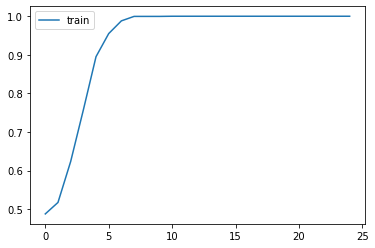

In [11]:
from matplotlib import pyplot
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2]),return_sequences=True,activation='relu'))
model.add(BatchNormalization())
model.add(LSTM(25, activation="relu"))
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32,activation='relu'))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])
# fit network
history = model.fit(train_X, train_y, epochs=25, shuffle=False)
# plot history
pyplot.plot(history.history['accuracy'], label='train')
pyplot.legend()
pyplot.show()

In [22]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 1, 50)             214000    
_________________________________________________________________
batch_normalization_1 (Batch (None, 1, 50)             200       
_________________________________________________________________
lstm_3 (LSTM)                (None, 25)                7600      
_________________________________________________________________
dense_3 (Dense)              (None, 128)               3328      
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)                4128      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                

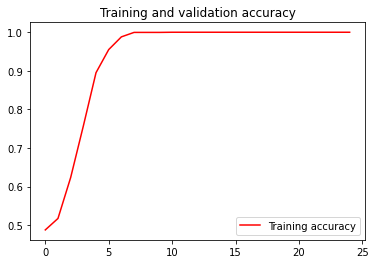

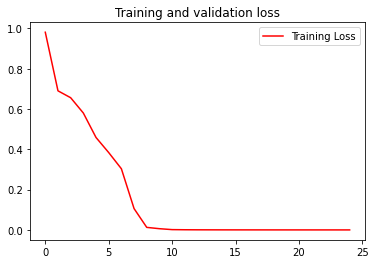

In [21]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
loss = history.history['loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [12]:
df_t = pd.read_csv("/content/drive/MyDrive/TEST_STUDY.csv")
df_t = df_t.iloc[:,1:]
df_t.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50
0,8968.0,1207.801586,1144.372342,1167.696396,484.791658,996.573137,169.372779,538.081093,875.782194,1437.664256,633.114039,1081.997885,1325.986383,624.119698,584.768840,985.868992,696.445757,256.130008,35.538209,130.839060,305.372783,197.570986,429.288183,432.438786,243.236401,656.552029,91.243562,53.132357,62.894885,162.278128,419.825361,144.638459,3.659605,60.560345,241.752692,220.697300,360.469444,450.554658,314.350905,80.324658,257.458923,18.971722,577.436166,255.602694,210.285614,559.120091,11.620255,479.786596,534.699027,146.783978,0.0
1,1265.0,5115.239108,9076.057154,1253.971902,7504.754727,255.974364,2366.869754,1536.018051,1657.920606,1234.247103,306.324244,70.497756,14.380554,620.340114,84.442817,120.148724,141.306402,165.430119,839.125953,417.458288,201.000191,117.306720,365.912045,238.337020,213.125102,465.815002,16.322970,143.266430,145.273956,275.915392,69.199740,478.100521,631.710257,247.224565,1059.081842,38.273415,481.354455,117.952091,55.734286,206.875578,310.347777,160.116815,124.707477,149.704785,308.148952,238.712667,22.406603,248.432822,104.648568,76.705248,0.0
2,2142.0,22397.623280,22404.365524,7434.827897,5542.395020,890.982780,1673.368410,944.410582,1120.780031,585.871299,613.921615,1094.758718,81.787310,204.813750,380.823353,69.220341,142.820645,249.608361,0.471641,305.791824,96.279323,280.034775,276.901751,279.644262,273.003621,180.573909,117.097447,211.712934,169.576472,87.277049,253.755579,134.216779,10.169852,233.416208,181.290095,237.977567,897.499489,335.250073,46.952932,71.978998,17.606133,40.417956,16.027326,126.738032,53.577273,91.038732,305.847764,198.372634,253.796776,416.384827,0.0
3,17818.0,1513.459077,314.971243,1589.402312,56.591281,32.680222,333.697609,437.408178,590.974214,330.217497,1261.217507,461.445058,1317.586484,243.059812,126.685042,89.742820,159.395779,308.595234,85.361145,307.214017,162.024169,340.915282,257.207027,230.042113,41.307146,211.910790,476.008232,167.706238,48.133863,236.815677,102.039812,37.445307,68.490296,62.763694,7.844947,491.300194,130.054193,32.499900,483.526586,124.769486,164.492115,199.283928,196.257390,81.079489,39.513172,202.147789,234.336833,35.479670,21.447272,211.195716,0.0
4,10758.0,3791.081595,2654.771859,1012.308239,778.173882,664.358878,174.948400,280.174874,820.977122,818.033219,53.236207,217.220310,265.849447,467.726089,102.290721,137.139090,119.973497,477.415080,460.628694,78.508006,639.489826,218.152687,239.914177,146.397493,50.654724,31.343459,333.272866,534.706202,73.573066,396.175457,335.001854,352.037625,186.170542,279.411589,431.872984,544.741790,469.794287,643.100657,725.645328,635.313793,340.865362,25.434210,405.978408,118.860179,216.401121,429.550937,222.115829,93.532373,455.160643,364.997864,0.0


In [13]:
X_test = df_t.values[:,:]

In [14]:
values = X_test.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_TEST = scaler.fit_transform(values)

In [15]:
scaled_TEST[:,-1] = 0

In [16]:
scaled_TEST.shape


(855, 51)

In [17]:
data_TEST = series_to_supervised(scaled_TEST, 10, 10)
print(data_TEST)

     var1(t-10)  var2(t-10)  var3(t-10)  ...  var49(t+9)  var50(t+9)  var51(t+9)
10     0.379160    0.053862    0.051054  ...    0.448554    0.074396         0.0
11     0.043605    0.228332    0.405087  ...    0.114089    0.228679         0.0
12     0.081809    1.000000    1.000000  ...    0.118670    0.307766         0.0
13     0.764680    0.067510    0.014034  ...    0.101610    0.338134         0.0
14     0.457135    0.169207    0.118472  ...    0.004671    0.008577         0.0
..          ...         ...         ...  ...         ...         ...         ...
841    0.481051    0.080378    0.085559  ...    0.030303    0.325690         0.0
842    0.444023    0.002501    0.130967  ...    0.106229    0.266502         0.0
843    0.442586    0.011220    0.086304  ...    0.109523    0.384003         0.0
844    0.449076    0.056347    0.053143  ...    0.259119    0.127331         0.0
845    0.425640    0.005725    0.006807  ...    0.110799    0.297325         0.0

[836 rows x 1020 columns]


In [18]:
test_X, test_y = data_TEST.values[:, :-1], data_TEST.values[:, -1]

In [19]:
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

In [20]:
print(model.evaluate(test_X,test_y))

27/27 [==============================] - 0s 2ms/step - loss: 0.2058 - accuracy: 0.9940
[0.20578335225582123, 0.9940191507339478]
